<a href="https://colab.research.google.com/github/orifelszer/CrimeData/blob/oriana-branch/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import glob
import pandas as pd
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

In [4]:
# הורדת הנתונים מה-GitHub
!git clone https://github.com/orifelszer/CrimeData.git

zip_folder = 'CrimeData'
# ✅ קריאה רק לקבצי ZIP לפי השנים 2019 עד 2024
zip_files = [f for f in os.listdir(zip_folder) if f.startswith('crimes') and any(str(year) in f for year in range(2019, 2025))]

# ✅ פריסת הקבצים ושמירה של נתיבי התיקיות החדשים
extracted_folders = []

for zip_file in zip_files:
    zip_path = os.path.join(zip_folder, zip_file)
    extract_path = os.path.join(zip_folder, zip_file.replace('.zip', ''))

    # Check if the directory already exists
    if not os.path.exists(extract_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Extracted: {zip_file} -> {extract_path}")
    else:
        print(f"Skipped: {zip_file} (Already extracted)")

    extracted_folders.append(extract_path)


Cloning into 'CrimeData'...
remote: Enumerating objects: 366, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 366 (delta 100), reused 18 (delta 18), pack-reused 188 (from 2)
Receiving objects: 100% (366/366), 211.21 MiB | 35.81 MiB/s, done.
Resolving deltas: 100% (183/183), done.
Extracted: crimes2019.zip -> CrimeData/crimes2019
Extracted: crimes2023.zip -> CrimeData/crimes2023
Extracted: crimes2021.zip -> CrimeData/crimes2021
Extracted: crimes2024.zip -> CrimeData/crimes2024
Extracted: crimes2020.zip -> CrimeData/crimes2020
Extracted: crimes2022.zip -> CrimeData/crimes2022


In [5]:
# ✅ איחוד קובצי CSV רק מהתיקיות שחולצו
csv_files = []
for folder in extracted_folders:
    csv_files += glob.glob(os.path.join(folder, "*.csv"))  # חיפוש כל קובצי ה-CSV בתיקיות שחולצו בלבד

In [7]:
# ✅ קריאת כל קובצי ה-CSV ושמירתם במילון לפי שם הקובץ
dataframes = {f"Crimes_{file[-8:-4]}": pd.read_csv(file) for file in csv_files}

In [8]:
# ✅ איחוד כל קובצי ה-CSV לקובץ אחד
combined_data = pd.concat(dataframes.values(), axis=0, ignore_index=True)

In [9]:
combined_data

,FictiveIDNumber,Year,Quarter,YeshuvKod,Yeshuv,PoliceDistrictKod,PoliceDistrict,PoliceMerhavKod,PoliceMerhav,PoliceStationKod,PoliceStation,municipalKod,municipalName,StatisticAreaKod,StatisticArea,StatisticGroupKod,StatisticGroup,StatisticTypeKod,StatisticType
0,9DF96CE4D6AB4649CECEAEFBAF3AF07C,2019,Q3,8400.0,רחובות,40000000,מחוז מרכז,41200000,מרחב שפלה,41212000,תחנת רחובות שפלה,NaN,NaN,84000222.0,אושיות,700,עבירות כלפי הרכוש,715,גניבות אחרות
1,BA008B3B18529E6E4C831139FDA8B172,2019,Q4,510.0,כפר מנדא,10000000,מחוז צפון,15002736,מרחב גליל צפון,12401000,תחנת משגב גליל צפון,NaN,NaN,NaN,NaN,600,עבירות כלפי המוסר,608,שמוש בסמים מסוכנים
2,1905BE9ECCA0AEDA4C4D13705F7A5672,2019,Q3,7000.0,לוד,40000000,מחוז מרכז,41200000,מרחב שפלה,41213000,תחנת לוד שפלה,NaN,NaN,70000022.0,גבעת הזיתים,700,עבירות כלפי הרכוש,712,גניבה מתוך רכב
3,5843D35EBA3C57AADF22435516ACD203,2019,Q3,8400.0,רחובות,40000000,מחוז מרכז,41200000,מרחב שפלה,41212000,תחנת רחובות שפלה,NaN,NaN,84000116.0,החלוץ/ העבודה,200,עבירות סדר ציבורי,220,עבירות על חוק הכניסה לישראל
4,BFF2C9D05A0250AFB2A4CB985FF2FA62,2019,Q1,6900.0,כפר סבא,40000000,מחוז מרכז,41100000,מרחב שרון,41112000,תחנת כפר סבא שרון,NaN,NaN,NaN,NaN,700,עבירות כלפי הרכוש,723,גניבת חלקי רכב
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2341168,BA52AC818358FA19FD7A9CB5DB60A42C,2022,Q2,3769.0,הר אדר,50000000,מחוז ירושלים,51200000,מרחב ציון ירושלים,51212000,תחנת הראל ציון,NaN,NaN,NaN,NaN,200,עבירות סדר ציבורי,206,איומים
2341169,059690968F6C2F1B81C5C53CCCEFBB5E,2022,Q3,3000.0,ירושלים,50000000,מחוז ירושלים,51200000,מרחב ציון ירושלים,51214000,תחנת לב הבירה ציון,NaN,NaN,30000832.0,מקור ברוך (מערב),700,עבירות כלפי הרכוש,715,גניבות אחרות
2341170,5E4A19D0471BA7E8FC1CD14B473DAD4F,2022,Q3,812.0,שלומי,80000000,מחוז חוף,15002761,מרחב אשר חוף,81501000,תחנת נהריה מחוז חוף,NaN,NaN,NaN,NaN,700,עבירות כלפי הרכוש,715,גניבות אחרות
2341171,304F64CF83DA884724D9217B2BE3800C,2022,Q3,195.0,קדימה צורן,40000000,מחוז מרכז,41100000,מרחב שרון,41118000,תחנת שדות שרון,NaN,NaN,1950001.0,NaN,700,עבירות כלפי הרכוש,719,גרימת נזק לרכוש בזדון


In [13]:

# Load data (replace with your combined_data after combining all years)
data = combined_data.copy()

# Prepare data for clustering and anomaly detection
# Aggregate by Year and Quarter for each StatisticGroup
crime_trends = (
    data.groupby(['Year', 'Quarter', 'StatisticGroup'])['FictiveIDNumber']
    .count()
    .reset_index()
    .rename(columns={'FictiveIDNumber': 'CrimeCount'})
)

# Map Quarter to numeric
quarter_mapping = {'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4}
crime_trends['QuarterNum'] = crime_trends['Quarter'].map(quarter_mapping)

# Feature engineering: Create a time index and pivot data for clustering
crime_trends['TimeIndex'] = crime_trends['Year'] + (crime_trends['QuarterNum'] - 1) / 4
crime_pivot = crime_trends.pivot_table(
    index='StatisticGroup', columns='TimeIndex', values='CrimeCount', fill_value=0
)

# Standardize data for clustering
scaler = StandardScaler()
crime_pivot_scaled = scaler.fit_transform(crime_pivot)



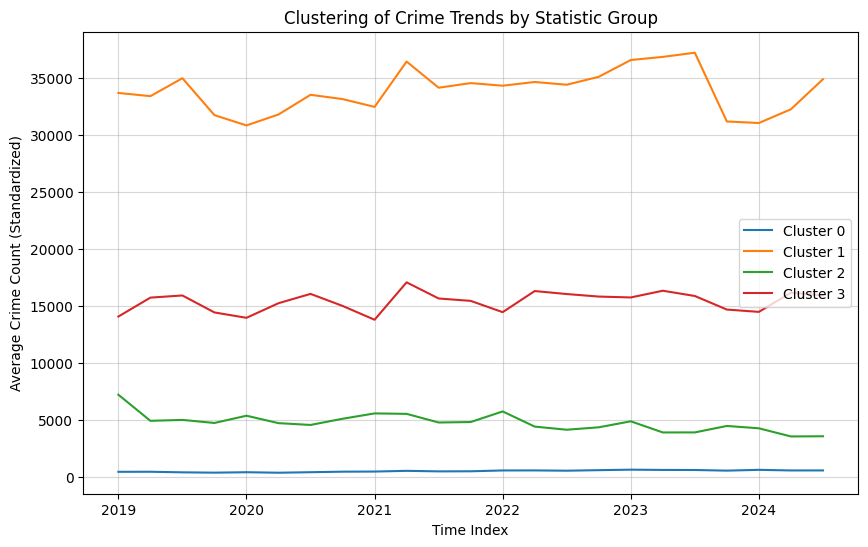

In [11]:
# Clustering with K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(crime_pivot_scaled)

# Add cluster labels to the original StatisticGroup data
crime_pivot['Cluster'] = clusters



# Visualization: Clustering Results
plt.figure(figsize=(10, 6))
for cluster in range(kmeans.n_clusters):
    cluster_data = crime_pivot[crime_pivot['Cluster'] == cluster]
    plt.plot(cluster_data.columns[:-2], cluster_data.iloc[:, :-2].mean(axis=0), label=f'Cluster {cluster}')

plt.title('Clustering of Crime Trends by Statistic Group')
plt.xlabel('Time Index')
plt.ylabel('Average Crime Count (Standardized)')
plt.legend()
plt.grid(alpha=0.5)
plt.show()



Clusters Overview:
Cluster 0 (Blue Line):

Represents statistic groups with the lowest crime counts over the entire period.
These groups remain consistently low and do not show significant variation over time.
Possible examples: Rare or less-reported crime types.
Cluster 1 (Orange Line):

Represents statistic groups with the highest crime counts.
Shows consistent activity over time but has notable peaks and dips:
The dip in 2020 aligns with COVID-19.
The drop in 2023 corresponds to the Israeli war.
Likely includes high-frequency crimes such as theft or property-related offenses.
Cluster 2 (Green Line):

Represents statistic groups with moderate but lower counts compared to Cluster 1.
The trend is relatively stable, with slight fluctuations.
Possible examples: Crimes that occur periodically, such as fraud or vandalism.
Cluster 3 (Red Line):

Represents statistic groups with medium-to-high crime counts.
Fluctuations are more prominent compared to Cluster 2, suggesting greater variability in occurrence.
Potentially includes crime types influenced by specific events or seasonal factors, such as violent crimes or drug-related offenses.
Key Insights:
Cluster 1 (Orange Line):

Dominates the overall trend, highlighting that a few statistic groups account for the majority of crimes.
Drops during major disruptions (COVID-19, war) suggest these are crimes dependent on normal societal activity (e.g., theft).
Cluster 3 (Red Line):

Fluctuations indicate these crimes might be more sensitive to external factors or enforcement actions.
Cluster 2 and Cluster 0:

Remain relatively stable and low, reflecting crimes that are either rare (Cluster 0) or less influenced by external events (Cluster 2).
How to Use This Insight:
Prioritize Resources:

Focus law enforcement efforts on statistic groups in Cluster 1 due to their high volume.
Monitor Cluster 3 for patterns that might indicate emerging risks.
Analyze Events:

Dive deeper into statistic groups in Clusters 1 and 3 to understand what causes their trends (e.g., policy changes, holidays, or major events).

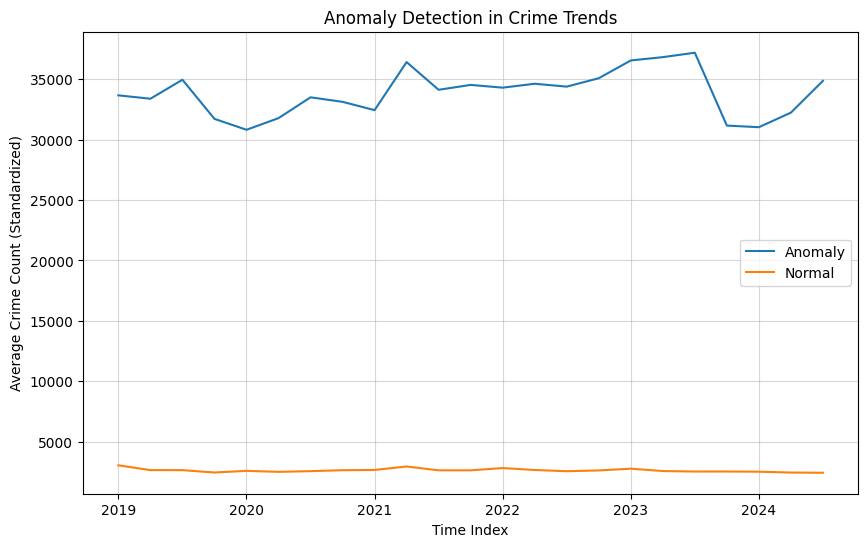

In [12]:
# Anomaly Detection with Isolation Forest
iso_forest = IsolationForest(random_state=42, contamination=0.1)
anomalies = iso_forest.fit_predict(crime_pivot_scaled)
crime_pivot['Anomaly'] = anomalies
# Visualization: Anomalies
plt.figure(figsize=(10, 6))
for anomaly in [-1, 1]:
    anomaly_data = crime_pivot[crime_pivot['Anomaly'] == anomaly]
    anomaly_label = 'Anomaly' if anomaly == -1 else 'Normal'
    plt.plot(anomaly_data.columns[:-2], anomaly_data.iloc[:, :-2].mean(axis=0), label=anomaly_label)

plt.title('Anomaly Detection in Crime Trends')
plt.xlabel('Time Index')
plt.ylabel('Average Crime Count (Standardized)')
plt.legend()
plt.grid(alpha=0.5)
plt.show()


COVID-19 in 2020:
Decreased Crime Rates:

During COVID-19 lockdowns, restrictions on movement likely reduced opportunities for crimes such as theft, burglary, and street violence.
Many countries observed similar declines in crime rates during the pandemic.
Possible Impact on the Graph:

The drop in anomalies around 2020 aligns with this period.
This suggests a reduction in unusual spikes in crime, likely due to the overall decrease in criminal activities during the pandemic.
Israel War (October 7, 2023):
Decreased Crime Rates During Conflict:

During wartime, the focus shifts to survival and defense, and normal societal activities are disrupted.
Law enforcement and public resources are often redirected toward managing the crisis, potentially reducing reported crimes like theft and public order violations.
Impact Seen in the Graph:

A sharp drop in anomalies around late 2023 matches the war's timeline.
This could indicate:
Fewer reported crimes during this time due to disrupted normal life.
The population and authorities focusing on safety and survival rather than everyday criminal activities.

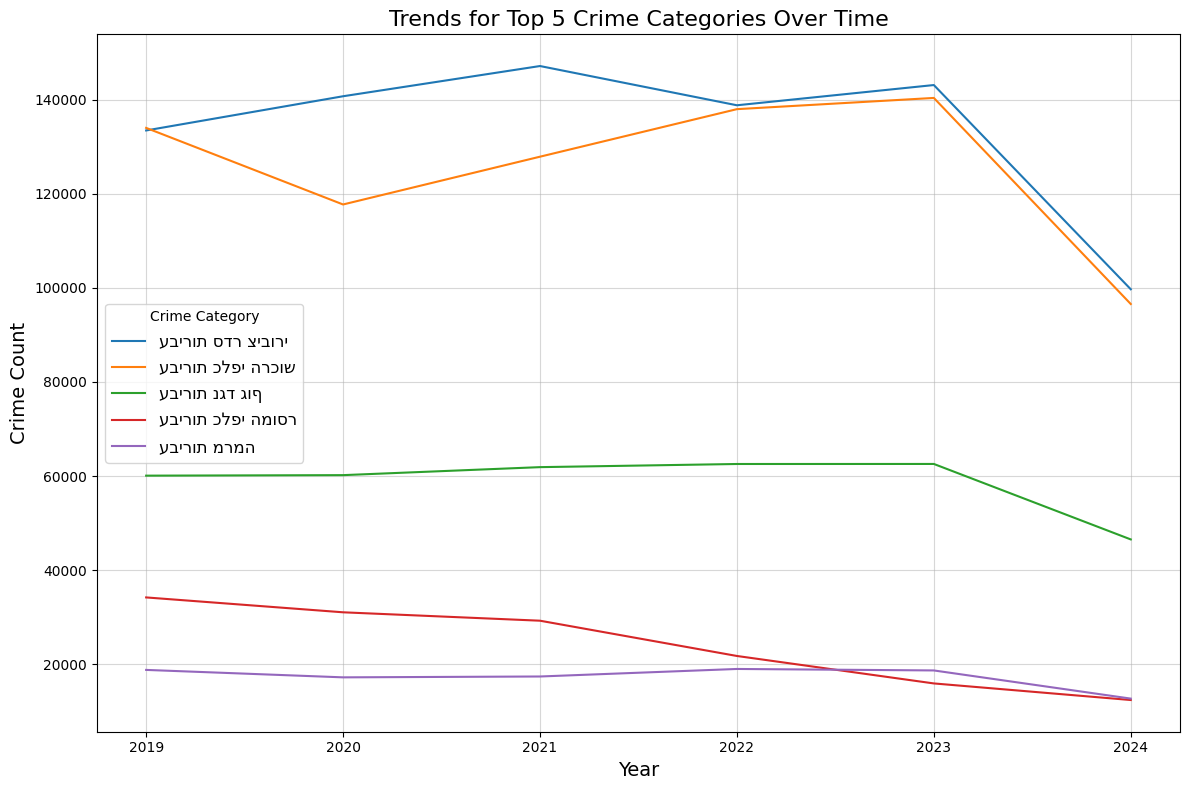

In [14]:
# Aggregate crime counts by StatisticGroup and Year
category_trends = data.groupby(['Year', 'StatisticGroup'])['FictiveIDNumber'].count().reset_index()
category_trends.rename(columns={'FictiveIDNumber': 'CrimeCount'}, inplace=True)

# Get the top 5 most frequent crime categories
top_categories = category_trends.groupby('StatisticGroup')['CrimeCount'].sum().nlargest(5).index

# Filter data for the top categories
top_category_trends = category_trends[category_trends['StatisticGroup'].isin(top_categories)]

# Plot trends for the top 5 categories
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

for category in top_categories:
    category_data = top_category_trends[top_category_trends['StatisticGroup'] == category]
    plt.plot(category_data['Year'], category_data['CrimeCount'], label=category)

# Customize the plot
plt.title('Trends for Top 5 Crime Categories Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Crime Count', fontsize=14)
plt.legend(title='Crime Category', fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()


['DejaVu Sans Mono', 'STIXSizeThreeSym', 'STIXNonUnicode', 'STIXSizeFiveSym', 'STIXSizeTwoSym', 'DejaVu Sans', 'cmr10', 'STIXGeneral', 'DejaVu Sans', 'DejaVu Sans', 'STIXGeneral', 'cmmi10', 'DejaVu Serif Display', 'DejaVu Serif', 'cmex10', 'DejaVu Sans Mono', 'cmb10', 'STIXNonUnicode', 'DejaVu Sans Mono', 'STIXNonUnicode', 'STIXSizeFourSym', 'DejaVu Serif', 'DejaVu Sans Display', 'DejaVu Serif', 'cmss10', 'STIXSizeThreeSym', 'DejaVu Sans Mono', 'STIXSizeTwoSym', 'DejaVu Sans', 'STIXSizeFourSym', 'STIXGeneral', 'STIXNonUnicode', 'cmtt10', 'cmsy10', 'STIXSizeOneSym', 'STIXSizeOneSym', 'DejaVu Serif', 'STIXGeneral', 'Liberation Serif', 'Liberation Serif', 'Liberation Sans Narrow', 'Liberation Mono', 'Liberation Sans', 'Liberation Sans', 'Liberation Sans Narrow', 'Liberation Sans', 'Liberation Sans Narrow', 'Liberation Mono', 'Humor Sans', 'Liberation Sans', 'Liberation Mono', 'Liberation Sans Narrow', 'Liberation Serif', 'Liberation Serif', 'Liberation Mono']


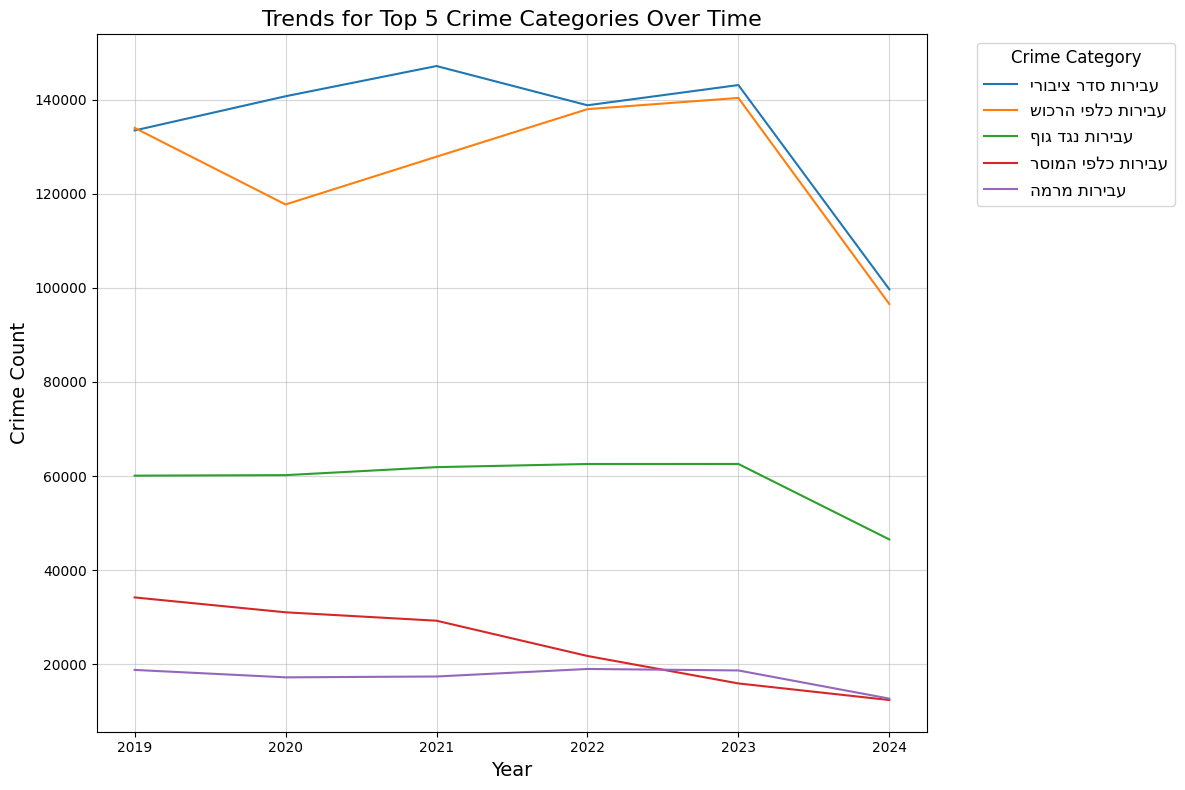

In [23]:
#!pip install python-bidi

import matplotlib.pyplot as plt
from bidi.algorithm import get_display  # Corrects text orientation
from matplotlib import rcParams


# Use DejaVu Sans (default font in Matplotlib)
rcParams['font.family'] = 'DejaVu Sans'
from matplotlib import font_manager
print([f.name for f in font_manager.fontManager.ttflist])
import warnings
warnings.filterwarnings("ignore", module="matplotlib")




# Set font that supports Hebrew and configure matplotlib
rcParams['font.family'] = 'Arial'  # Ensure Arial (or Hebrew-supported font) is installed
rcParams['axes.unicode_minus'] = False

# Correcting the mirrored Hebrew using `bidi`
top_categories_display = [get_display(category) for category in top_categories]

# Replot the graph with fixed labels
plt.figure(figsize=(12, 8))

for category, category_display in zip(top_categories, top_categories_display):
    category_data = top_category_trends[top_category_trends['StatisticGroup'] == category]
    plt.plot(category_data['Year'], category_data['CrimeCount'], label=category_display)

# Customize the plot
plt.title(get_display('Trends for Top 5 Crime Categories Over Time'), fontsize=16)
plt.xlabel(get_display('Year'), fontsize=14)
plt.ylabel(get_display('Crime Count'), fontsize=14)
plt.legend(
    title=get_display('Crime Category'),
    fontsize=12,
    loc='upper left',
    title_fontsize=12,
    bbox_to_anchor=(1.05, 1)
)
plt.grid(alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

